In [1]:
import geopandas as gpd
import geemap
from outils.initializeGEE import initializeEarthEngine
from indexes.sentinel2IndexCalculator import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from numpy.linalg import LinAlgError

# Configure visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# Initialize Google Earth Engine
initializeEarthEngine()

True

In [2]:
gdf = gpd.read_parquet('data/farmPropertiesAnonymized.parquet')

In [3]:
# Load indigenous territories data from parquet file
# Only the first 3 territories are selected for this example
gdf = gpd.read_parquet('data/farmPropertiesAnonymized.parquet')

# Convert GeoDataFrame to Earth Engine FeatureCollection
# This is necessary to use the geometries in Google Earth Engine
gdf_ee = geemap.geopandas_to_ee(gdf)

# Configuration parameters for satellite imagery analysis
start_date = '2020-01-01'
end_date = '2024-12-31'
batch_size = 10  # Number of features to process in each batch

# Create an instance of Sentinel2IndexCalculator
# This calculator will handle the retrieval and processing of Sentinel-2 imagery
calculator = Sentinel2IndexCalculator(
    start_date, 
    end_date, 
    gdf_ee,  
    id_column='hash_id',  # Column containing unique identifiers for each territory
    batch_size=batch_size    # Process features in batches to avoid memory issues
)

# Calculate NDVI (Normalized Difference Vegetation Index) for all territories
# NDVI is a measure of vegetation health and density
print(f"Calculating NDVI for {len(gdf)} territories from {start_date} to {end_date}...")
ndvi_df = calculator.calculate_single_index('ndvi')

# Display summary statistics of the resulting NDVI values
print(f"NDVI calculation complete. Results shape: {ndvi_df.shape}")
print("\nNDVI Summary Statistics:")
print(ndvi_df.describe())

# Save results to CSV (optional)
output_file = f"ndvi_results_{start_date.replace('-', '')}_{end_date.replace('-', '')}.csv"
ndvi_df.to_csv(output_file)
print(f"Results saved to {output_file}")

Calculating NDVI for 5 territories from 2020-01-01 to 2024-12-31...


Processing NDVI: 100%|██████████| 182/182 [04:41<00:00,  1.55s/it]

NDVI calculation complete. Results shape: (9090, 3)

NDVI Summary Statistics:
              ndvi
count  2903.000000
mean      0.256775
std       0.161390
min      -0.072554
25%       0.160415
50%       0.257541
75%       0.342509
max       0.837062
Results saved to ndvi_results_20200101_20241231.csv


### Time series visualization of raw NDVI from Sentinel-2 data

Visualization saved to ndvi_visualization_20200101_20241231.png


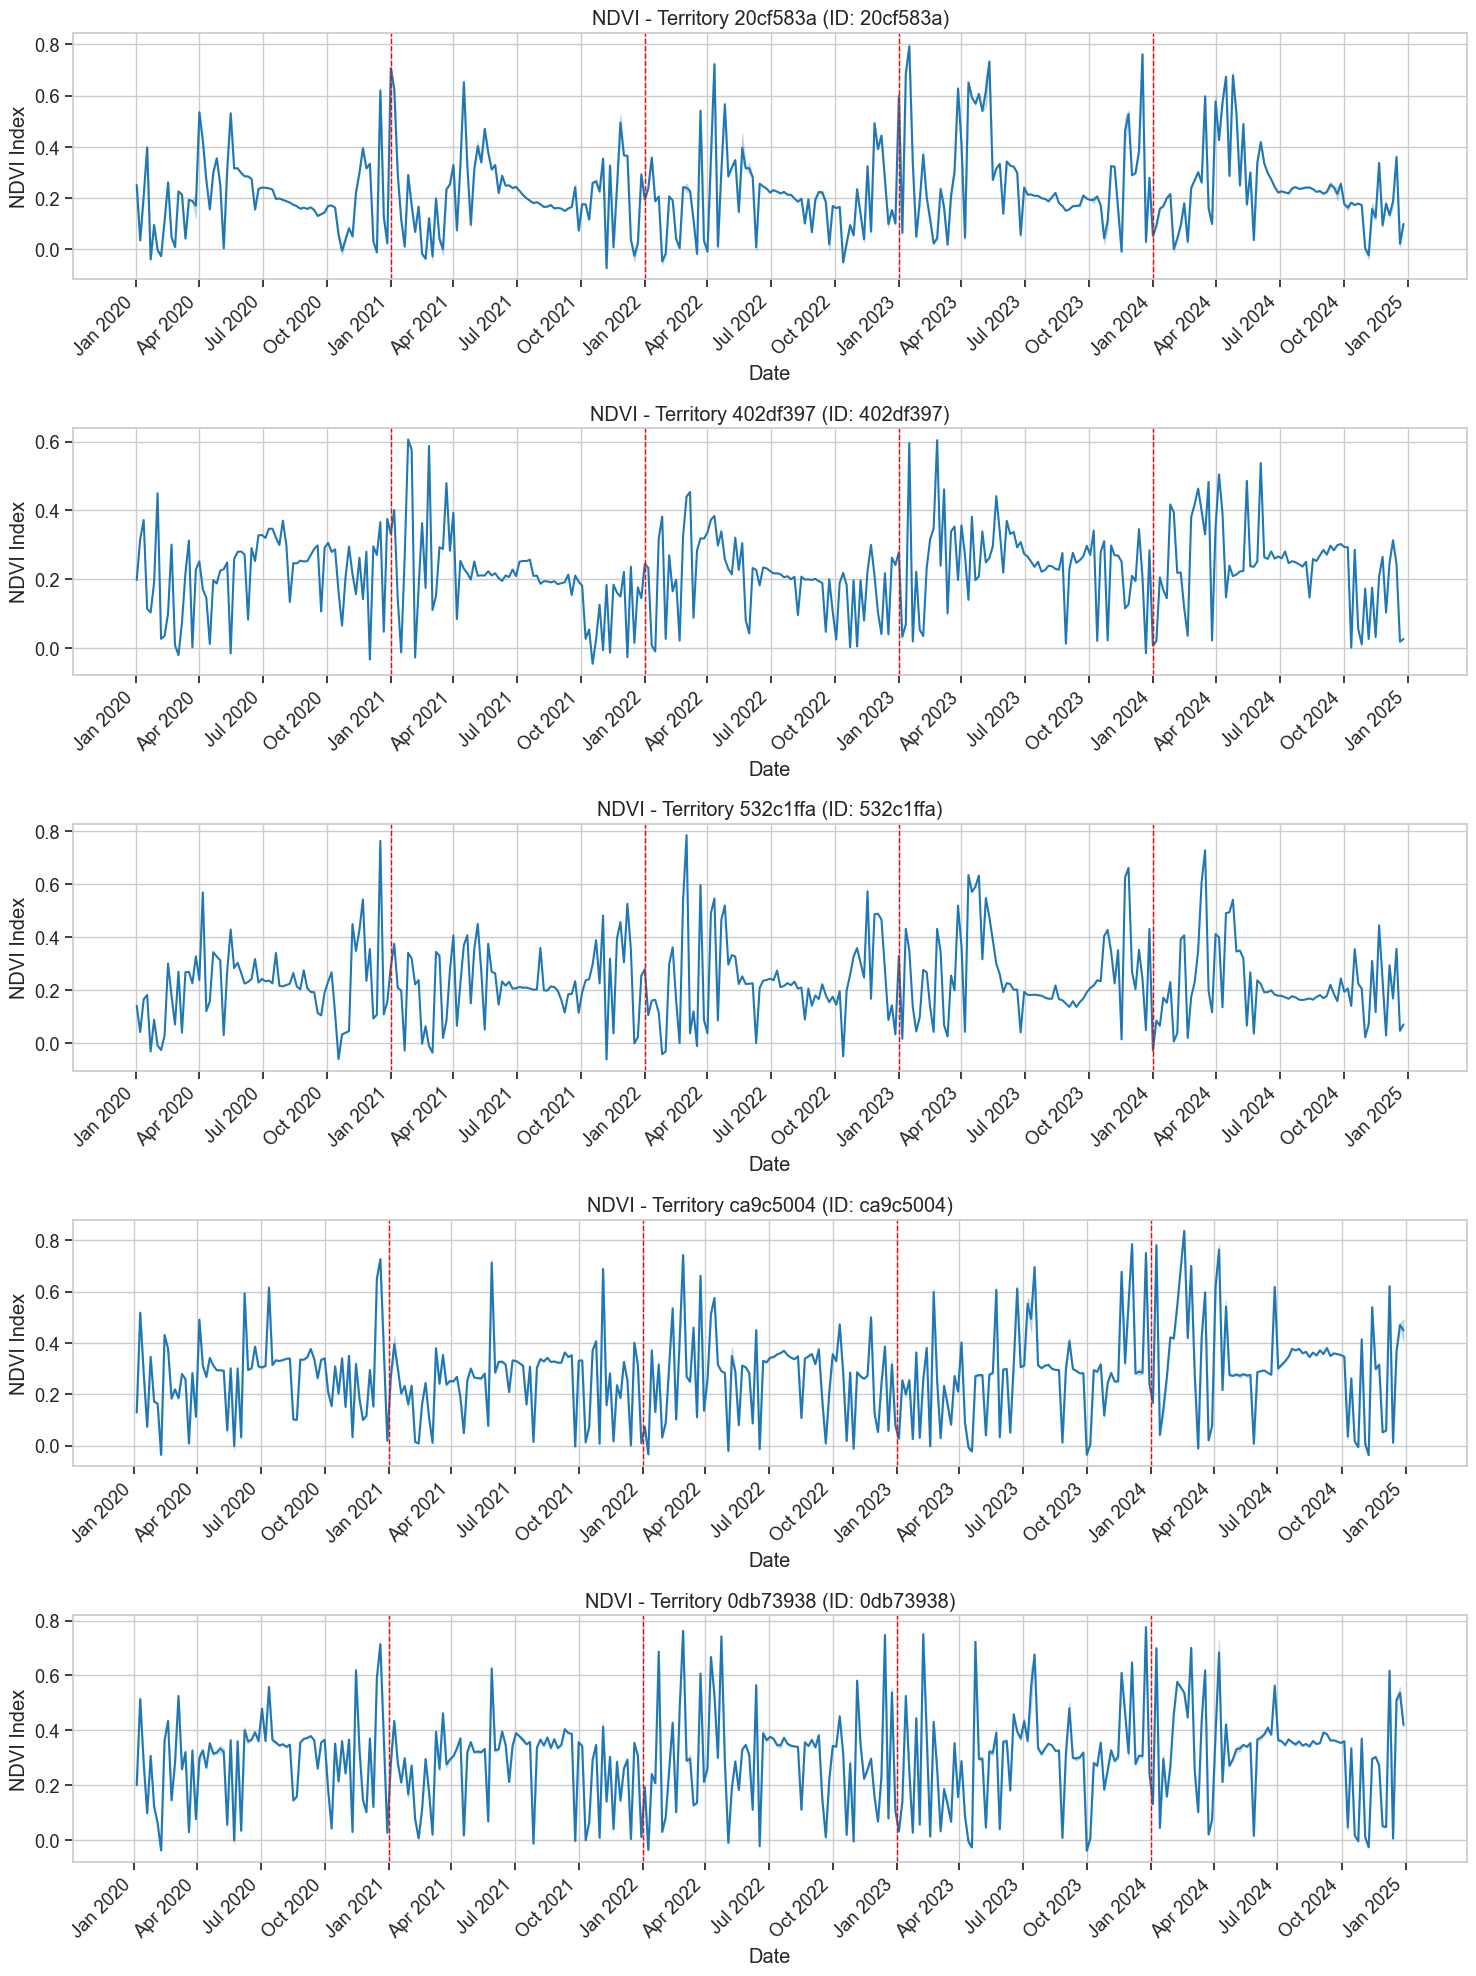

In [4]:
# Step 1: Convert date column to datetime format with correct format recognition
# The dates are in 'dd-mm-yyyy' format, so we use dayfirst=True
ndvi_df['date'] = pd.to_datetime(ndvi_df['date'], dayfirst=True)

# Step 2: Select random territories to visualize (5 samples or fewer if there are less territories)
unique_territories = ndvi_df['hash_id'].unique()
territories_to_plot = np.random.choice(
    unique_territories, 
    min(5, len(unique_territories)), 
    replace=False
)

# Step 3: Create a multi-panel figure, one panel per territory
fig, axes = plt.subplots(
    len(territories_to_plot), 
    1, 
    figsize=(15, 4*len(territories_to_plot))
)

# Handle the case where there's only one territory (axes would be a single object, not a list)
if len(territories_to_plot) == 1:
    axes = [axes]

# Step 4: Plot NDVI time series for each selected territory
for i, territory_id in enumerate(territories_to_plot):
    # Filter data for the current territory
    territory_data = ndvi_df[ndvi_df['hash_id'] == territory_id].copy()
    
    # Sort data by date to ensure proper time series plotting
    territory_data = territory_data.sort_values('date')
    
    # Plot the NDVI values
    sns.lineplot(
        x='date', 
        y='ndvi', 
        data=territory_data, 
        ax=axes[i],
        linewidth=1.5
    )
    
    # Get territory name if available, otherwise use ID
    territory_name = territory_data.iloc[0].get('name', f'Territory {territory_id}')
    
    # Add title and labels
    axes[i].set_title(f'NDVI - {territory_name} (ID: {territory_id})')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('NDVI Index')
    
    # Format x-axis to show dates every three months
    axes[i].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add vertical red lines at the beginning of each year to highlight seasonality
    # Get the minimum and maximum years in the data
    min_year = territory_data['date'].dt.year.min()
    max_year = territory_data['date'].dt.year.max()
    
    # Draw a vertical line at the start of each year
    for year in range(min_year, max_year + 1):
        year_start_date = pd.to_datetime(f'{year}-01-01')
        # Check if the year date is within our data range
        if (year_start_date >= territory_data['date'].min()) and (year_start_date <= territory_data['date'].max()):
            axes[i].axvline(
                year_start_date, 
                color='red',       # Red line
                linestyle='--',    # Dashed line
                linewidth=1        # Line width
            )

# Adjust spacing between subplots to prevent overlap
plt.tight_layout()

# Save the visualization as a high-resolution image
file_name = f"ndvi_visualization_{start_date.replace('-', '')}_{end_date.replace('-', '')}.png"
fig.savefig(file_name, dpi=300, bbox_inches='tight')
print(f"Visualization saved to {file_name}")

# Display the plots
plt.show()

### Temporal analysis of vegetation indices with daily interpolation and signal smoothing

Applying daily interpolation to create a continuous time series...
Applying robust smoothing to NDVI time series...
Applying smoothing with combined median + Gaussian filter...
Selecting territories for visualization...
Creating visualizations...
Visualization saved to ndvi_daily_smoothed_20200101_20241231.png


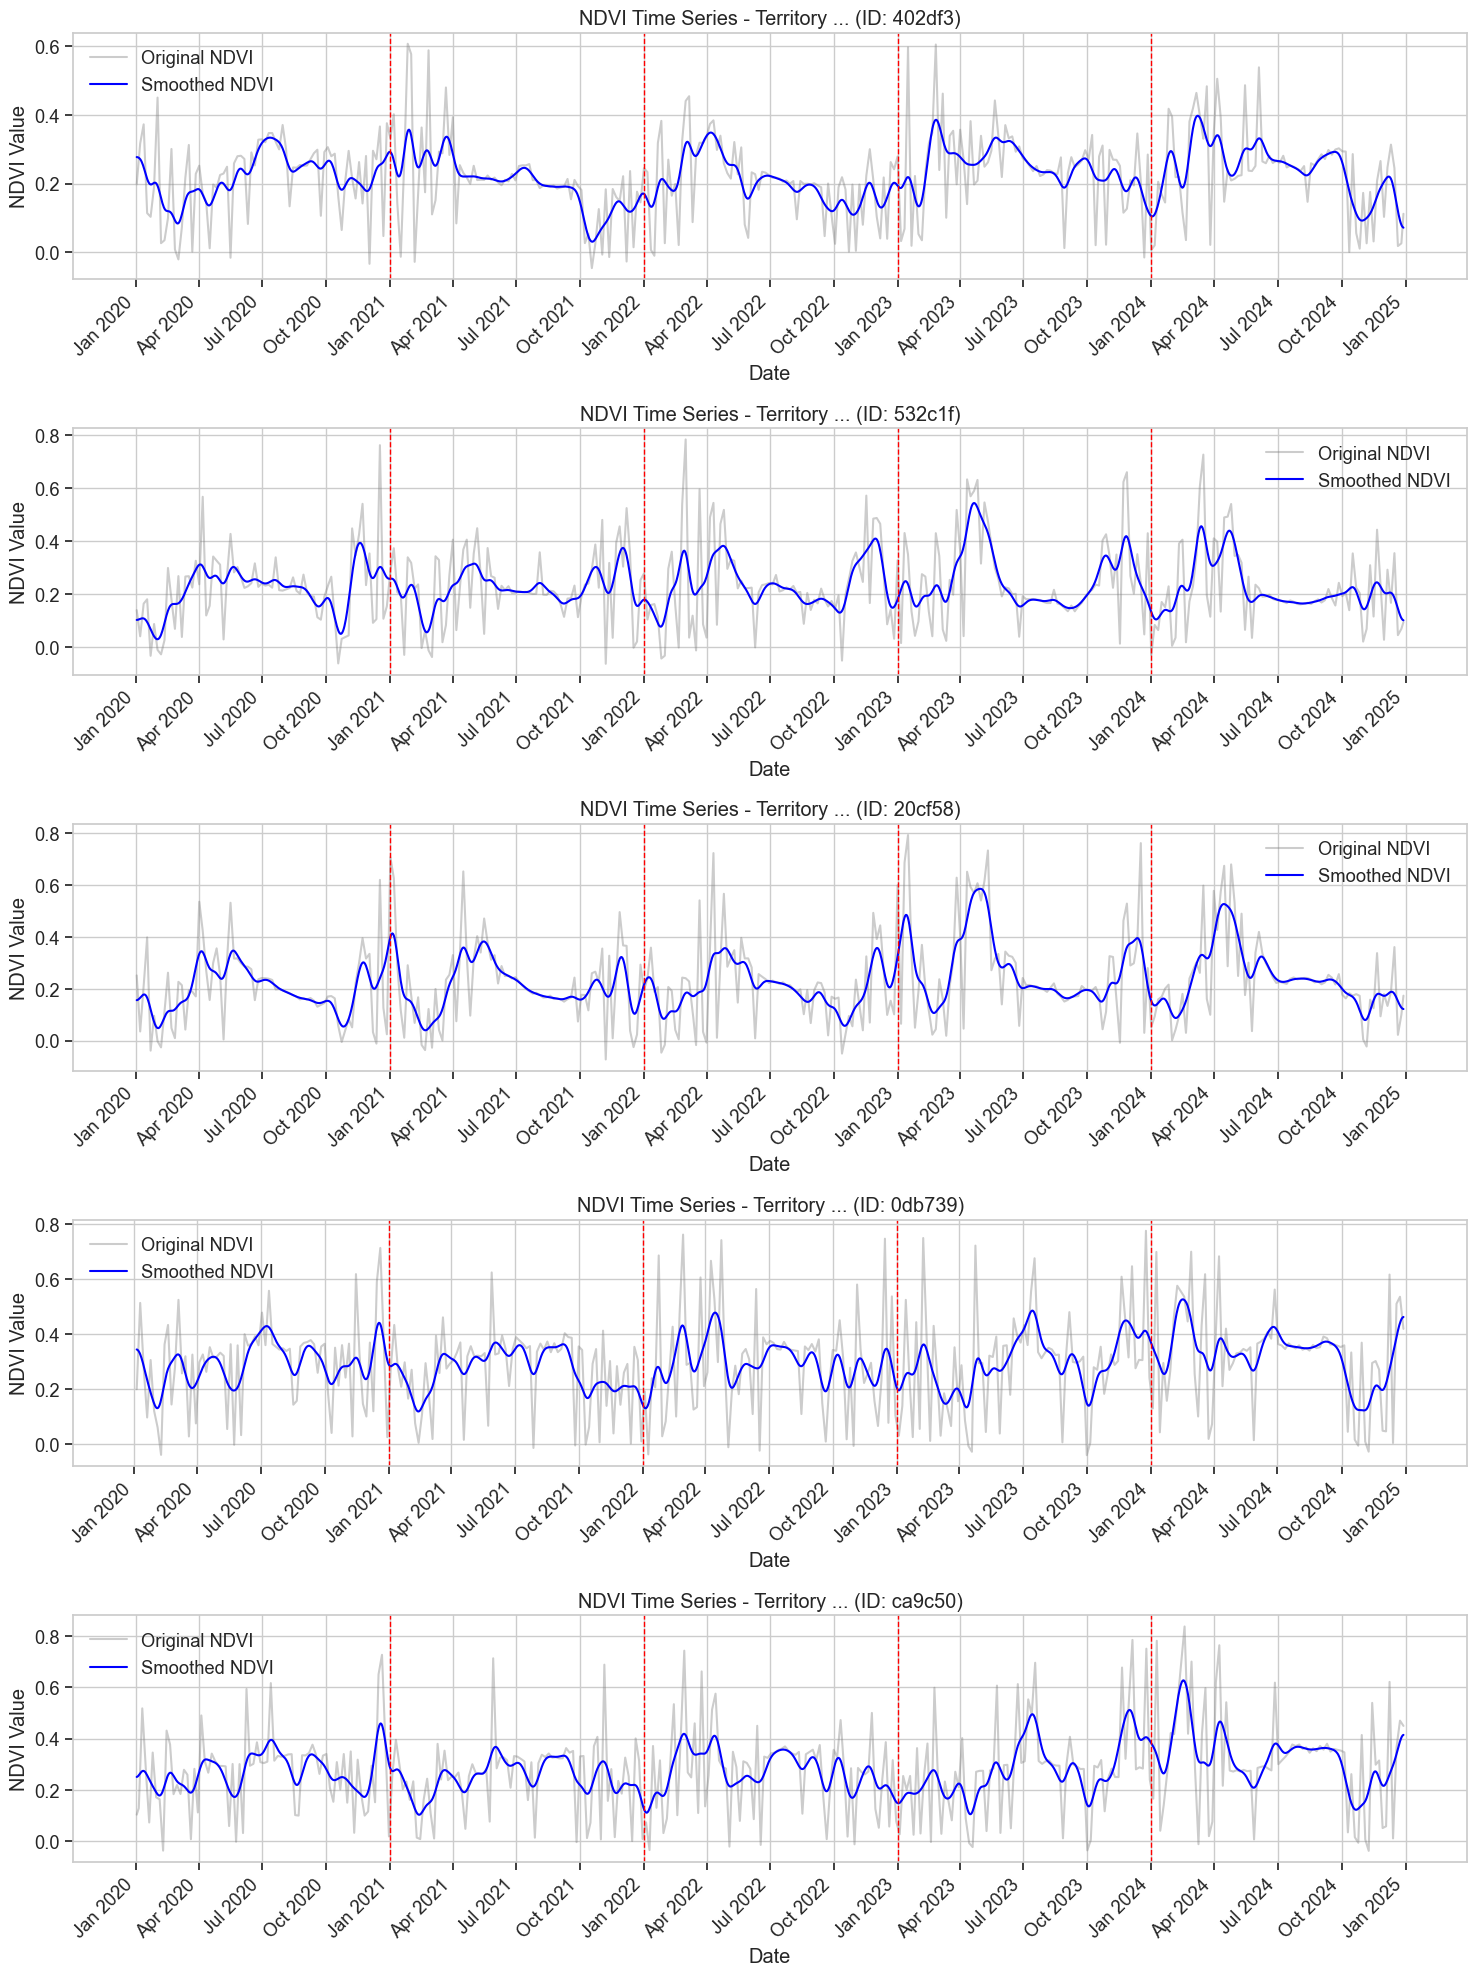


Summary statistics of the processed NDVI data:
              ndvi  ndvi_smooth
count  9117.000000  9117.000000
mean      0.251373     0.251374
std       0.134952     0.089324
min      -0.072469     0.031151
25%       0.167261     0.188457
50%       0.240349     0.240452
75%       0.330210     0.309569
max       0.836969     0.627134

Total number of daily observations after interpolation: 9117
Number of territories analyzed: 5
Date range: 2020-01-02 to 2024-12-29


In [11]:
# Temporal analysis of vegetation indices with daily interpolation and signal smoothing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.ndimage import gaussian_filter1d  # More stable than savgol_filter

# Step 1: Convert date column to datetime format
# The dates are in 'dd-mm-yyyy' format, so we use dayfirst=True
ndvi_df['date'] = pd.to_datetime(ndvi_df['date'], dayfirst=True)

# Step 2: Apply daily interpolation to fill gaps in the time series
# First, set territory ID and date as a hierarchical index
print("Applying daily interpolation to create a continuous time series...")
ndvi_df.set_index(['hash_id', 'date'], inplace=True)

# Resample to daily frequency and interpolate missing values
# This creates a smooth daily time series from potentially irregular observations
ndvi_df = ndvi_df.groupby('hash_id').resample('D', level='date').mean()
ndvi_df = ndvi_df.interpolate(method='linear')

# Reset index to return to a standard DataFrame structure
ndvi_df.reset_index(inplace=True)

# Step 3: Apply robust smoothing to the NDVI signal
# We'll use a combination of rolling median and Gaussian filter instead of Savitzky-Golay
print("Applying robust smoothing to NDVI time series...")

# Function to apply a robust two-step smoothing process
def apply_robust_smoothing(series):
    # Step 1: Apply rolling median to remove outliers and spikes
    # This is more robust to extreme values than moving average
    window = min(7, len(series) // 3)  # Adaptive window size
    if window < 3:
        window = 3  # Minimum window size
    if window % 2 == 0:
        window += 1  # Ensure odd window size
        
    rolling_median = series.rolling(window=window, center=True, min_periods=1).mean()
    
    # Step 2: Apply Gaussian filter for additional smoothing
    # This provides a gentle smoothing effect without edge artifacts
    sigma = 7.0  # Controls smoothness - higher values = smoother curve
    smoothed = gaussian_filter1d(rolling_median, sigma=sigma)
    
    return smoothed

# Apply the robust smoothing to each territory's NDVI time series
print("Applying smoothing with combined median + Gaussian filter...")
ndvi_df['ndvi_smooth'] = ndvi_df.groupby('hash_id')['ndvi'].transform(apply_robust_smoothing)

# Drop any remaining NaN values that might exist after processing
ndvi_df.dropna(subset=['ndvi'], inplace=True)

# Step 4: Select random territories to visualize
print("Selecting territories for visualization...")
unique_territories = ndvi_df['hash_id'].unique()
territories_to_plot = np.random.choice(
    unique_territories, 
    min(5, len(unique_territories)), 
    replace=False
)

# Step 5: Create a multi-panel figure for visualization
fig, axes = plt.subplots(
    len(territories_to_plot), 
    1, 
    figsize=(15, 4*len(territories_to_plot))
)

# Handle the case where there's only one territory
if len(territories_to_plot) == 1:
    axes = [axes]

# Step 6: Plot NDVI time series for each selected territory
print("Creating visualizations...")
for i, territory_id in enumerate(territories_to_plot):
    # Filter data for the current territory
    territory_data = ndvi_df[ndvi_df['hash_id'] == territory_id].copy()
    
    # Plot the original NDVI values (with lighter appearance)
    sns.lineplot(
        x='date', 
        y='ndvi', 
        data=territory_data, 
        ax=axes[i],
        alpha=0.4,  # Semi-transparent to show as background
        color='gray',
        label='Original NDVI'
    )
    
    # Plot the smoothed NDVI values (main visualization)
    sns.lineplot(
        x='date', 
        y='ndvi_smooth', 
        data=territory_data, 
        ax=axes[i],
        linewidth=1.5,
        color='blue',
        label='Smoothed NDVI'
    )
    
    # Get territory name if available
    territory_name = territory_data.iloc[0].get('name', f'Territory {territory_id}')
    
    # Add title and labels
    axes[i].set_title(f'NDVI Time Series - {territory_name[:10]}... (ID: {territory_id[:6]})')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('NDVI Value')
    
    # Format x-axis to show dates every three months
    axes[i].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add vertical red lines at the beginning of each year
    min_year = territory_data['date'].dt.year.min()
    max_year = territory_data['date'].dt.year.max()
    
    # Draw a vertical line at the start of each year
    for year in range(min_year, max_year + 1):
        year_start_date = pd.to_datetime(f'{year}-01-01')
        # Check if the year date is within our data range
        if (year_start_date >= territory_data['date'].min()) and (year_start_date <= territory_data['date'].max()):
            axes[i].axvline(
                year_start_date, 
                color='red',
                linestyle='--',
                linewidth=1
            )
    
    # Add legend
    axes[i].legend()

# Adjust spacing between subplots to prevent overlap
plt.tight_layout()

# Save the visualization as a high-resolution image
file_name = f"ndvi_daily_smoothed_{start_date.replace('-', '')}_{end_date.replace('-', '')}.png"
fig.savefig(file_name, dpi=300, bbox_inches='tight')
print(f"Visualization saved to {file_name}")

# Display the plots
plt.show()

# Print summary statistics about the processed data
print("\nSummary statistics of the processed NDVI data:")
print(ndvi_df[['ndvi', 'ndvi_smooth']].describe())

print(f"\nTotal number of daily observations after interpolation: {len(ndvi_df)}")
print(f"Number of territories analyzed: {ndvi_df['hash_id'].nunique()}")
print(f"Date range: {ndvi_df['date'].min().strftime('%Y-%m-%d')} to {ndvi_df['date'].max().strftime('%Y-%m-%d')}")